In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import re
import requests
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

Peterson starts with: reddit 
Peterson ends with: Leave a comment

# Get Zizek url's
Zizek's pages are embedded w/'posted-on', so pull them by looking for them

In [2]:
zizek_article_ls = []

pages = ["https://zizek.uk/category/article/lecture/",
            "https://zizek.uk/category/article/lecture/page/2/"]

for page in pages:
    
    r = requests.get(page)
    data = r.content
    soup = BeautifulSoup(data, "html.parser")

    for content in soup.find_all('span',{'class':'posted-on'}):
       link = content.find('a',href=True)
       if link is None:
           continue
       zizek_article_ls.append(link['href'])


Remove first link (it's also a compendium of lecture transcripts')

In [3]:
zizek_article_ls = zizek_article_ls[3:]

In [4]:
zizek_article_ls[:2]

['https://zizek.uk/slavoj-zizek-the-courage-of-hopelessness-may-2017/',
 'https://zizek.uk/is-lacan-an-anti-philosopher-23-slavoj-zizek-transcript/']

# Get Zizek Data

Now we actually get Zizek's data; credit to this post:

https://stackoverflow.com/questions/22799990/beatifulsoup4-get-text-still-has-javascript

In [5]:
# Munge doc takes in a url & returns its text content as a list of words

def munge_doc(url,start_token,end_token): 
    page = urlopen(Request(url, headers={'User-Agent': 'Mozilla/5.0'}))
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html, "html.parser")
    for script in soup(["script", "style"]):
        script.decompose()    
    
    text = soup.get_text()
    
    lines = (line.strip() for line in text.splitlines())
    
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    
    # drop blank lines & replace escape characters/quotes
    text = '\n'.join(chunk for chunk in chunks if chunk).replace("’", 
                                                                 "").replace("'",
                                                                             "").replace("'\'", 
                                                                                         "")
    
    text = text.replace('zizek',
                        '').replace('Zizek',
                                            '').replace('Žižek',
                                                                '')
    text = text.replace(' se ','')
    
    # locate words & subset list to start/end token
    words = re.findall(r'\w+', text)
    
    words_out = words[words.index(start_token)+1:words.index(end_token)]

    return words

Note for zizek the start token is 'Lectures' and stop is 'friendsClick', based on my understanding of page layout. We excise the first 50 tokens & the last 400, since those are mostly intros & links to social media:

In [6]:
zizek_doc_ls = []
zizek_urls_used = []

# loop over articles in zizek list, append docs/urls to running lists
for article in zizek_article_ls:
    doc = munge_doc(article,'Lectures','friendsClick')
    doc = doc[50:-400]
    
    # ignore short docs
    if len(doc) < 100:
        continue
        
    zizek_urls_used.append(article)
    zizek_doc_ls.append(doc)

Now, we sanity check to see how many words Zizek gave us back, and find that if we were to chunk articles into ~250 words each, we would have ~400 samples

In [7]:
import itertools

len(list(itertools.chain.from_iterable(zizek_doc_ls)))

99349

In [8]:
100000/250

400.0

# Get Peterson url's
We go through the list of JBP's transcripts on his site to get relevant transcripts:

In [9]:
jbp_article_ls = []

pages = ["https://www.jordanbpeterson.com/transcripts/"]

for page in pages:
    
    r = requests.get(page)
    data = r.content  
    soup = BeautifulSoup(data, "html.parser")

    # 
    for i in soup.find_all('h4',{'class':'entry-title'}):
       link = i.find('a',href=True)
       if link is None:
           continue
       jbp_article_ls.append(link['href'])


# Get JBP Data
JBP interviews formatted a bit differently, so we handle by excising text from his other speakers. Additionally, we note their acroynms from these pages (e.g., LH for Lewis Howes)

In [10]:
interview_ls = [('https://www.jordanbpeterson.com/transcripts/douglas-murray/','DM'),
 ('https://www.jordanbpeterson.com/transcripts/transliminal/','JL'),
 ('https://www.jordanbpeterson.com/transcripts/lewis-howes/','LH'),
 ('https://www.jordanbpeterson.com/transcripts/lewis-howes-2/','LH'),
 ('https://www.jordanbpeterson.com/transcripts/aubrey-marcus/','AM'),
 ('https://www.jordanbpeterson.com/transcripts/ben-shapiro-1/','BS'),
 ('https://www.jordanbpeterson.com/transcripts/russell-brand-2/','RB')]

In [11]:
jbp_doc_ls = []
jbp_urls_used = []
for interview_tup in interview_ls:
    page = urlopen(Request(interview_tup[0], headers={'User-Agent': 'Mozilla/5.0'}))
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html,"lxml")
    
    # the 'd' class will tell us where his text lives
    doc_pre = soup.body.find('div', attrs={'class':'d'}).get_text()
    
    # use regexp to find when JP stops/starts speaking
    doc = re.sub(interview_tup[1]+':[^JP]+JP', '',doc_pre)
    
    # if, for whatever reason, source is too brief, cut it
    if len(doc) < 100:
        continue
        
    jbp_urls_used.append(interview_tup[0])
    
    # excise 'jp'
    jbp_doc_ls.append(doc.lower().replace("’", "").replace("'",
                                                   "").replace("'\'", 
                                                               "").replace('jp',
                                                                           '').replace('rb',''))

# Process data

Now we munge data to make it cleaner; first we remove first 200 characters for each JBP speech, last 50 for JBP (already munged Zizek)

In [12]:
jbp_doc_ls = [x[200:-50] for x in jbp_doc_ls]

In [13]:
jbp_docs_tokenized = [re.findall(r'\w+', x) for x in jbp_doc_ls]

### Get all docs together
We make a final list of tokens for jbp and zizek

In [14]:
jbp_token_ls = list(itertools.chain.from_iterable(jbp_docs_tokenized))

In [15]:
zizek_token_ls = list(itertools.chain.from_iterable(zizek_doc_ls))

In [16]:
len(zizek_token_ls)

99349

In [17]:
len(jbp_token_ls)

65790

Now we chunk our JBP/Zizek lists into documents of 250 tokens in length (single string):

In [18]:
jbp_docs_final = []
for i in range(0, len(jbp_token_ls), 250):
    jbp_docs_final.append(' '.join(jbp_token_ls[i:i + 500]))

In [19]:
zizek_docs_final = []
for i in range(0, len(zizek_token_ls), 250):
    zizek_docs_final.append(' '.join(zizek_token_ls[i:i + 500]))

### Shuffle data/label
Now we shuffle our docs, then label them accordingly s.t. our holdout will eventually be 40 jbp & 40 zizek snippets. The logic behind the shuffling here is that when we validate our alphas, we want the training data to properly represent a diverse set of documents

In [20]:
import random
random.seed(42)

In [21]:
random.shuffle(zizek_docs_final)

In [22]:
random.shuffle(jbp_docs_final)

Define train data as noted above:

In [23]:
train_zizek_docs = zizek_docs_final[:-40]
train_jbp_docs = jbp_docs_final[:-40]

In [24]:
len(train_zizek_docs)

358

In [25]:
len(train_jbp_docs)

224

In [26]:
full_train_corpus = train_zizek_docs + train_jbp_docs

In [27]:
len(full_train_corpus)

582

# Train model
Now, we build out a pipeline of vectorizing words --> Multinomial Naïve Bayes, fit via grid search. The grid search is partially used to find best alpha, but more chiefly to check out-of-sample performance

### Vectorize text

In [28]:
nb_pipe = Pipeline([
     ('vect', CountVectorizer(max_features=1000,stop_words='english',strip_accents='unicode')),
     ('clf', MultinomialNB()),
])
params = {  
'clf__alpha': (0.001, 0.0001, 0.00001)  
}  
nb_clf = GridSearchCV(nb_pipe,params,cv=StratifiedKFold(n_splits=5, shuffle=True,
                                                        random_state=42))

In [29]:
y_train = [0]*358 + [1]*224

In [30]:
len(y_train)

582

In [31]:
nb_clf.fit(full_train_corpus,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor...nizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__alpha': (0.001, 0.0001, 1e-05)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
nb_clf.best_estimator_.named_steps['clf']

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

# Test model
We have 40 holdout examples from JBP & Zizek, respectively; we score our model on these:

In [33]:
test_zizek_docs = zizek_docs_final[-40:]
test_jbp_docs = jbp_docs_final[-40:]

In [34]:
full_test_corpus = test_zizek_docs + test_jbp_docs

In [35]:
y_test = [0]*40 + [1]*40

In [36]:
nb_clf.score(full_test_corpus,y_test)

1.0

In [37]:
import numpy as np

# EDA
For some Exploratory Data Analysis, we want to look at which words had the most outsize impact on our model:

In [38]:
import matplotlib.pyplot as plt

In [39]:
vocab_dict = nb_clf.best_estimator_.named_steps['vect'].vocabulary_

vocab_keys = sorted(vocab_dict.keys())

In [40]:
def eda(author,ind):

    nb_clf.best_estimator_.named_steps['clf'].feature_log_prob_.shape

    arg_ranks = sorted(nb_clf.best_estimator_.named_steps['clf'].feature_log_prob_[ind],
                       reverse=True)

    top_args = np.argsort(nb_clf.best_estimator_.named_steps['clf'].feature_log_prob_[ind])[:5]

    plt.figure(figsize=(7,3))
    plt.bar(x=[vocab_keys[i] for i in top_args],
            height=[abs(x) for x in arg_ranks[:5]])
    plt.title('Top 5 '+author+' words (by neg. log prob)',fontsize=17,weight='bold')
    plt.ylabel('Log prob of word (neg)')
    plt.xlabel('Word',fontsize=12)

    plt.show()

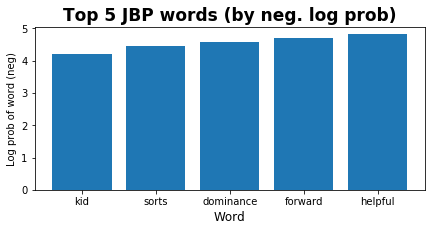

In [41]:
eda('JBP',0)

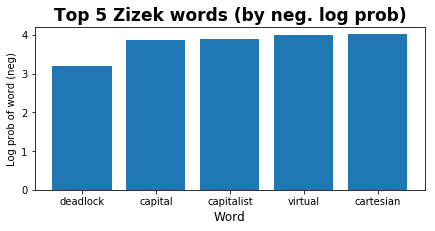

In [42]:
eda('Zizek',1)

# Export pipeline

In [43]:
import pickle

In [44]:
pickle.dump( nb_clf, open( "nb_vect.p", "wb" ) )